In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
import os
import ast
import torch
import json
import random
import numpy as np
import networkx as nx
import plotly.graph_objects as go
from community import community_louvain

feature_matrix=pd.read_csv('../../data/all_features_dataframe.csv')
interaction_matrix=pd.read_csv('../../data/voting_interaction_matrix.csv', index_col=0)


Explained Variance by each component: [3.99843486e-02 2.89556111e-02 1.98144448e-02 ... 8.95667213e-05
 8.92878562e-05 8.92060453e-05]
Number of components chosen: 1521


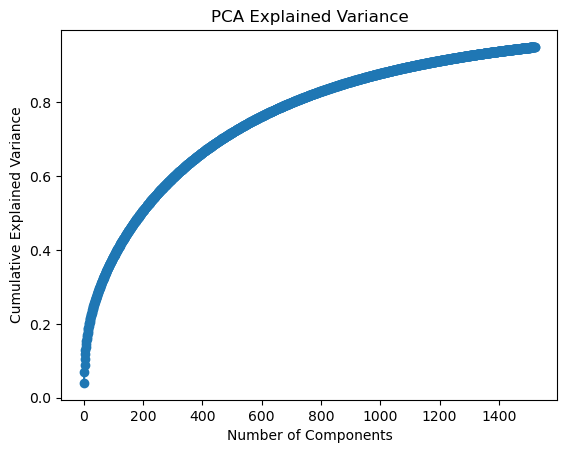

In [8]:
#cluster interaction matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Perform PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
reduced_data = pca.fit_transform(interaction_matrix)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance by each component: {explained_variance}")
print(f"Number of components chosen: {pca.n_components_}")

# Plot cumulative explained variance
plt.plot(range(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.show()

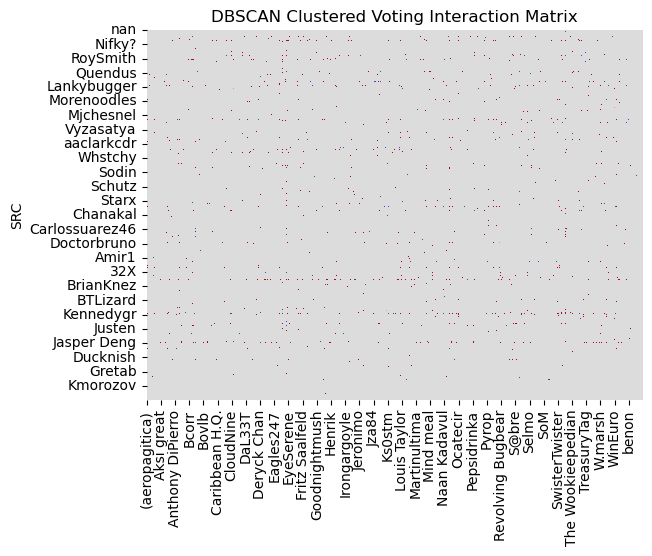

nuber of cluster: 21
Cluster labels: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [36]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert the matrix to NumPy (DBSCAN requires a NumPy array)
data = interaction_matrix.values

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=10)  # Adjust parameters as needed
clusters = dbscan.fit_predict(data)

# Add cluster labels to the DataFrame
interaction_matrix['Cluster'] = clusters

# Sort the DataFrame by clusters
sorted_matrix = interaction_matrix.sort_values("Cluster")

# Exclude the 'Cluster' column for heatmap visualization
sns.heatmap(sorted_matrix.iloc[:, :-1], cmap="coolwarm", cbar=False)
plt.title("DBSCAN Clustered Voting Interaction Matrix")
plt.show()

# Print cluster labels to check results
print('nuber of cluster:',len(np.unique(clusters)))
print("Cluster labels:", np.unique(clusters))

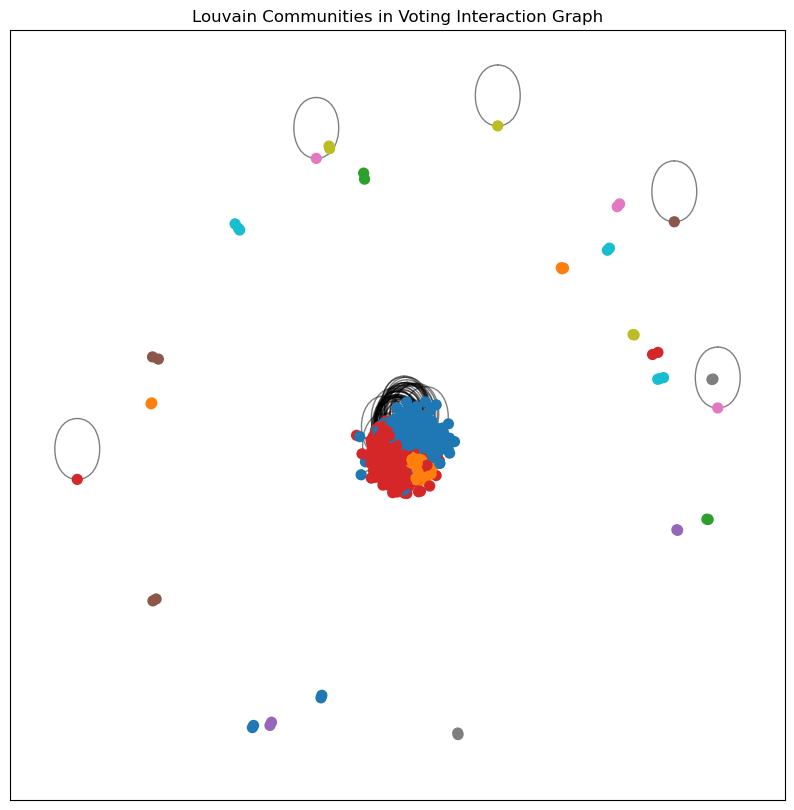

User: nan, Community: 1
User: (aeropagitica), Community: 1
User: 23skidoo, Community: 1
User: @pple, Community: 9
User: AYArktos, Community: 1
User: Aaron Brenneman, Community: 1
User: Abela2006, Community: 1
User: Acetic Acid, Community: 1
User: Agathoclea, Community: 1
User: Airplaneman, Community: 9
User: Alex S, Community: 1
User: AlexandrDmitri, Community: 9
User: AlexiusHoratius, Community: 9
User: Alison, Community: 9
User: Ambuj.Saxena, Community: 1
User: AndonicO, Community: 9
User: Andrew c, Community: 9
User: Andrwsc, Community: 1
User: Andy5190, Community: 1
User: Antandrus, Community: 1
User: Appleboy, Community: 1
User: Arkyan, Community: 9
User: Arvindn, Community: 1
User: Audi152, Community: 1
User: Avruch, Community: 9
User: Babajobu, Community: 1
User: Backslash Forwardslash, Community: 9
User: Bahamut0013, Community: 9
User: Banaticus, Community: 9
User: Bastique, Community: 1
User: Bbb23, Community: 9
User: Bduke, Community: 9
User: Bellhalla, Community: 9
User: Ben

In [ ]:
#louvain cluster
import pandas as pd
import networkx as nx
from community import community_louvain
import matplotlib.pyplot as plt

# Create a graph from the interaction matrix
# We'll assume a weighted undirected graph where the weight is the voting interaction (1 or 0)
G = nx.Graph()

# Add edges for each voting interaction
for user in interaction_matrix.index:
    for admin, vote in interaction_matrix.loc[user].items():
        if vote > 0:  # Only consider positive voting interactions
            G.add_edge(user, admin, weight=vote)

# Apply the Louvain algorithm
resolution=1
partition = community_louvain.best_partition(G, resolution=resolution)

# Add the detected communities as attributes to the graph nodes
nx.set_node_attributes(G, partition, "community")

# Analyze and visualize the communities
# Plot the graph with nodes colored by community
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)  # Layout for better visualization
colors = [partition[node] for node in G.nodes()]
nx.draw_networkx_nodes(G, pos, node_color=colors, cmap=plt.cm.tab10, node_size=50)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Louvain Communities in Voting Interaction Graph")
plt.show()

# Print the partition (user-community mapping)
for user, community in partition.items():
    print(f"User: {user}, Community: {community}")


In [30]:
num_communities = len(set(partition.values()))
print(f"Number of communities detected: {num_communities}")


Number of communities detected: 27


In [40]:
# Count the number of users in each community
community_sizes = {}
for node, community in partition.items():
    if community not in community_sizes:
        community_sizes[community] = 0
    community_sizes[community] += 1

# Create a new graph to represent the communities
community_graph = nx.Graph()

# Add community nodes with sizes as attributes
for community, size in community_sizes.items():
    community_graph.add_node(community, size=size)

# Add edges between communities based on the original graph
for node1, node2 in G.edges:
    community1 = partition[node1]
    community2 = partition[node2]
    if community1 != community2:  # Only add inter-community edges
        if not community_graph.has_edge(community1, community2):
            community_graph.add_edge(community1, community2, weight=0)
        community_graph[community1][community2]['weight'] += 1

# Create positions for Plotly visualization
pos = nx.spring_layout(community_graph)

# Extract node positions and attributes
node_x = []
node_y = []
node_sizes = []
node_text = []
for node, coords in pos.items():
    node_x.append(coords[0])
    node_y.append(coords[1])
    node_sizes.append(community_graph.nodes[node]['size'] * 10)  # Scale size for better visibility
    node_text.append(f"Community {node}<br>Users: {community_graph.nodes[node]['size']}")

# Extract edge positions and weights
edge_x = []
edge_y = []
edge_text = []
for edge in community_graph.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])
    edge_text.append(f"Edge Weight: {edge[2]['weight']}")

# Create the Plotly figure
fig = go.Figure()

# Add edges to the graph
fig.add_trace(go.Scatter(
    x=edge_x,
    y=edge_y,
    line=dict(width=0.5, color="#888"),
    hoverinfo='text',
    mode='lines',
    text=edge_text
))

# Add nodes to the graph
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    marker=dict(
        size=node_sizes,
        color=list(community_graph.nodes),
        colorscale='Viridis',
        line=dict(width=2, color='black')
    ),
    text=node_text,
    hoverinfo='text'
))

# Set layout
fig.update_layout(
    title="Interactive Community Graph",
    showlegend=False,
    xaxis=dict(showgrid=False, zeroline=False),
    yaxis=dict(showgrid=False, zeroline=False),
    height=800,
    width=800
)

fig.show()